### Importing required libraries

In [145]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_v2_preprocess_input

### Using MobileNetV2 as Transfer learned model on Imagenet dataset

In [146]:
model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3), include_top=True, weights='imagenet')

In [147]:
def load_imagenet_labels(file_path):
  labels_file = tf.keras.utils.get_file('ImageNetLabels.txt', file_path)
  with open(labels_file) as reader:
    f = reader.read()
    labels = f.splitlines()
  return np.array(labels)

### Loading Imagenet labels

In [148]:
imagenet_labels = load_imagenet_labels('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
print(imagenet_labels)

['background' 'tench' 'goldfish' ... 'bolete' 'ear' 'toilet tissue']


### Load and preprocess images

In [149]:
def read_image(file_name):
  image = tf.io.read_file(file_name)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)  
  image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
  return image

In [150]:
img = {'Peacock':'Peacock.jpg'}

In [151]:
print(img.items())

dict_items([('Peacock', 'Peacock.jpg')])


In [152]:
img_name_tensors = {name: read_image(img_path) for (name, img_path) in img.items()}

### Display the original input image

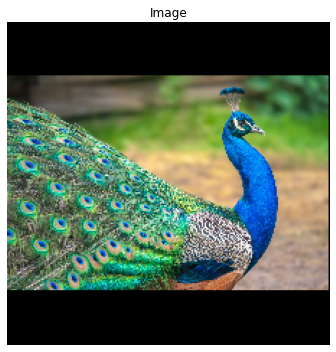

In [153]:
plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)
ax.imshow(img_name_tensors['Peacock'])
ax.set_title("Image")aa
ax.axis('off')
plt.tight_layout()

### Predict the top three predictions from the model for the input image

In [154]:
def top_k_predictions(img, k=3):
  image = tf.expand_dims(img, 0)
  predictions = model(image)
  probs = tf.nn.softmax(predictions, axis=-1)
  top_probs, top_idxs = tf.math.top_k(input=probs, k=k)
  top_labels = np.array(tuple(top_idxs[0]) )
  return top_labels, top_probs[0]

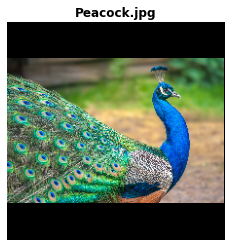

peacock: 0.2%
ostrich: 0.1%
bath towel: 0.1%


In [155]:
#Display the image with top 3 prediction from the model
plt.imshow(img_name_tensors['Peacock'])
plt.title("Peacock.jpg", fontweight='bold')
plt.axis('off')
plt.show()

pred_label, pred_prob = top_k_predictions(img_name_tensors['Peacock'])
for label, prob in zip(pred_label, pred_prob):
    print(f'{imagenet_labels[label+1]}: {prob:0.1%}')

### Create a black baseline image which will act as a starting point for calculating feature importance

In [156]:
baseline = tf.zeros(shape=(224,224,3))

### Generate linear interpolation between baseline and the original input image

In [157]:
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

In [158]:
print(alphas.shape)
print(alphas)

(51,)
tf.Tensor(
[0.         0.02       0.04       0.06       0.08       0.09999999
 0.12       0.14       0.16       0.17999999 0.19999999 0.22
 0.24       0.26       0.28       0.29999998 0.32       0.34
 0.35999998 0.38       0.39999998 0.42       0.44       0.45999998
 0.48       0.5        0.52       0.53999996 0.56       0.58
 0.59999996 0.62       0.64       0.65999997 0.68       0.7
 0.71999997 0.74       0.76       0.78       0.79999995 0.82
 0.84       0.85999995 0.88       0.9        0.91999996 0.94
 0.96       0.97999996 1.        ], shape=(51,), dtype=float32)


In [159]:
def interpolate_images(baseline,
                       image,
                       alphas):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(image, axis=0)
  delta = input_x - baseline_x
  images = baseline_x +  alphas_x * delta
  return images

In [160]:
interpolated_images = interpolate_images(
    baseline=baseline,
    image=img_name_tensors['Peacock'],
    alphas=alphas)

### Visualizing the interpolated image

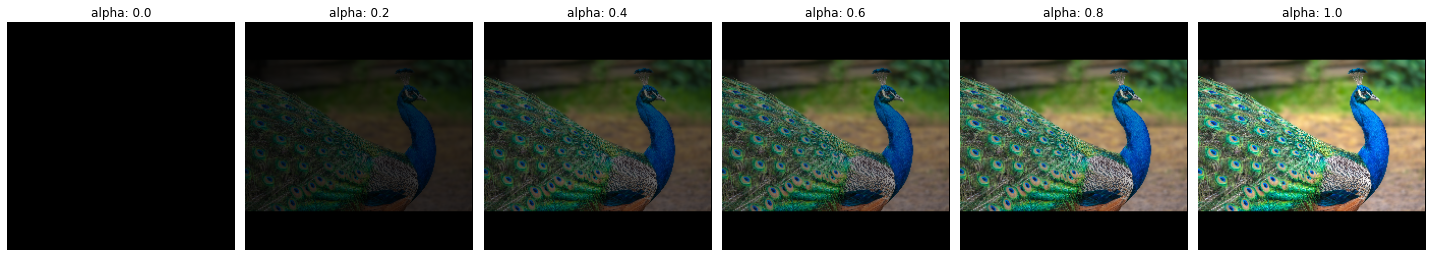

In [161]:
fig = plt.figure(figsize=(20, 20))
i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image)
  plt.axis('off')
plt.tight_layout();

### Compute gradients between model outputs and interpolated inputs

In [162]:
def compute_gradients(images, target_class_idx):
  with tf.GradientTape() as tape:
    tape.watch(images)
    logits = model(images)
    probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
  return tape.gradient(probs, images)

In [163]:
path_gradients = compute_gradients(
    images=interpolated_images,
    target_class_idx=84)

In [164]:
print(path_gradients.shape)

(51, 224, 224, 3)


### Accumulate the Gradients using the Riemann Trapezoid

In [165]:
def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients

### Putting all the steps in a single function to calculate the integrated gradients

In [166]:
#@tf.function
def integrated_gradients(baseline, 
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=1):
    # 1. Generate alphas.
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)
    # Initialize TensorArray outside loop to collect gradients.
    gradient_batches = tf.TensorArray(tf.float32, size=m_steps+1)
    # Iterate alphas range and batch computation for speed, memory #efficiency, and scaling to larger m_steps.
    for alpha in tf.range(0, len(alphas), batch_size):
        from_ = alpha
        to = tf.minimum(from_ + batch_size, len(alphas))
        alpha_batch = alphas[from_:to]
    # 2. Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline, image=image, alphas=alpha_batch)
    # 3. Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch, target_class_idx=target_class_idx)
    # Write batch indices and gradients to extend TensorArray.
    gradient_batches = gradient_batches.scatter(tf.range(from_, to), gradient_batch)
    # Stack path gradients together row-wise into single tensor.
    total_gradients = gradient_batches.stack()
    # 4. Integral approximation through averaging gradients.
    avg_gradients = integral_approximation(gradients=total_gradients)
    # 5. Scale integrated gradients with respect to input.
    integrated_gradients = (image - baseline) * avg_gradients
    return integrated_gradients

In [167]:
ig_attributions = integrated_gradients(baseline=baseline, 
                                       image=img_name_tensors['Peacock'], 
                                       target_class_idx=84, 
                                       m_steps=283)

In [168]:
print(ig_attributions.shape)

(224, 224, 3)


### Visualizing the attribution and the Integrated gradient to explain the prediction for the input image

In [173]:
def plot_img_IG(baseline, 
                image, 
                target_class_idx,
                m_steps=50,
                cmap=None,
                overlay_alpha=0.4):
    attributions = integrated_gradients(baseline=baseline, 
                                        image=image, 
                                        target_class_idx=target_class_idx, 
                                        m_steps=m_steps)
    attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)
    fig, axs = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize= (8, 8))
    axs[0, 0].set_title('Attribution mask')
    axs[0, 0].imshow(attribution_mask, cmap=cmap)
    axs[0, 0].axis('off')
    axs[0, 1].set_title('Overlay IG on Input image ')
    axs[0, 1].imshow(attribution_mask, cmap=cmap)
    axs[0, 1].imshow(image, alpha=overlay_alpha)
    axs[0, 1].axis('off')
    plt.tight_layout()
    return fig

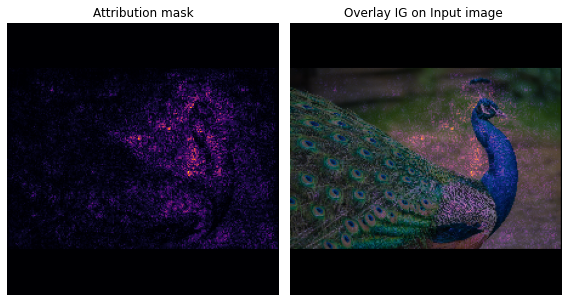

In [174]:
_ = plot_img_IG(image=img_name_tensors['Peacock'],
                baseline=baseline,
                target_class_idx=84,
                m_steps=240,
                cmap=plt.cm.inferno,
                overlay_alpha=0.4)